## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
from tensorflow.python import keras

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2


def build_mlp(input_shape,
              output_units=10,
              num_neurons=[512, 256, 128],
              ratio=1e-4,
              regularization_li=True):
    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if regularization_li:
                x = keras.layers.Dense(
                    units=n_units,
                    activation="relu",
                    name="hidden_layer" + '_l1_' + str(i + 1),
                    kernel_regularizer=l1(ratio))(input_layer)
            else:
                x = keras.layers.Dense(
                    units=n_units,
                    activation="relu",
                    name="hidden_layer" + '_l1_l2_' + str(i + 1),
                    kernel_regularizer=l1_l2(ratio))(input_layer)
        else:
            if regularization_li:
                x = keras.layers.Dense(
                    units=n_units,
                    activation="relu",
                    name="hidden_layer" + '_l1_' + str(i + 1),
                    kernel_regularizer=l1_l2(ratio))(x)
            else:
                x = keras.layers.Dense(
                    units=n_units,
                    activation="relu",
                    name="hidden_layer" + '_l1_l2_' + str(i + 1),
                    kernel_regularizer=l1_l2(ratio))(x)

    out = keras.layers.Dense(
        units=output_units, activation="softmax", name="output")(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

Using TensorFlow backend.


In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
for regulizer_ratio in EXP:
    for i in range(2):
        keras.backend.clear_session()  # 把舊的 Graph 清掉
        print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
        model = build_mlp(
            input_shape=x_train.shape[1:],
            ratio=regulizer_ratio,
            regularization_li=i == 0)
        model.summary()
        optimizer = keras.optimizers.SGD(
            lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(
            loss="categorical_crossentropy",
            metrics=["acc"],
            optimizer=optimizer)

        model.fit(
            x_train,
            y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=(x_test, y_test),
            shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-" + 'l1' if i == 0 else 'l1_l2' + "-%s" % str(
            regulizer_ratio)
        results[exp_name_tag] = {
            'train-loss': train_loss,
            'valid-loss': valid_loss,
            'train-acc': train_acc,
            'valid-acc': valid_acc
        }

Experiment with Regulizer = 0.010000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer_l1_1 (Dense)    (None, 512)               1573376   
_________________________________________________________________
hidden_layer_l1_2 (Dense)    (None, 256)               131328    
_________________________________________________________________
hidden_layer_l1_3 (Dense)    (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [======

Epoch 1/50
50000/50000 [==============================] - 2s 50us/sample - loss: 197.9694 - acc: 0.2440 - val_loss: 36.0343 - val_acc: 0.2589
Epoch 2/50
50000/50000 [==============================] - 2s 40us/sample - loss: 15.9550 - acc: 0.1069 - val_loss: 5.1486 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 2s 39us/sample - loss: 3.2163 - acc: 0.0990 - val_loss: 2.4716 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 2s 39us/sample - loss: 2.4632 - acc: 0.0990 - val_loss: 2.4622 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 2s 39us/sample - loss: 2.4624 - acc: 0.0984 - val_loss: 2.4622 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 2s 40us/sample - loss: 2.4624 - acc: 0.0990 - val_loss: 2.4620 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 39us/sample - loss: 2.4623 - acc: 0.0980 - val_loss: 2.4622 - val_acc: 0.1000
Epoch 8/50
50000/50000 

50000/50000 [==============================] - 2s 43us/sample - loss: 10.7681 - acc: 0.2620 - val_loss: 10.1648 - val_acc: 0.3311
Epoch 2/50
50000/50000 [==============================] - 2s 37us/sample - loss: 9.7109 - acc: 0.3505 - val_loss: 9.2833 - val_acc: 0.3589
Epoch 3/50
50000/50000 [==============================] - 2s 37us/sample - loss: 8.9076 - acc: 0.3717 - val_loss: 8.5492 - val_acc: 0.3810
Epoch 4/50
50000/50000 [==============================] - 2s 37us/sample - loss: 8.2267 - acc: 0.3879 - val_loss: 7.9164 - val_acc: 0.3918
Epoch 5/50
50000/50000 [==============================] - 2s 38us/sample - loss: 7.6411 - acc: 0.4001 - val_loss: 7.3727 - val_acc: 0.4066
Epoch 6/50
50000/50000 [==============================] - 2s 37us/sample - loss: 7.1370 - acc: 0.4091 - val_loss: 6.9022 - val_acc: 0.4154
Epoch 7/50
50000/50000 [==============================] - 2s 37us/sample - loss: 6.7000 - acc: 0.4170 - val_loss: 6.4986 - val_acc: 0.4204
Epoch 8/50
50000/50000 [============

Epoch 2/50
50000/50000 [==============================] - 2s 39us/sample - loss: 16.1379 - acc: 0.3551 - val_loss: 14.9867 - val_acc: 0.3617
Epoch 3/50
50000/50000 [==============================] - 2s 40us/sample - loss: 13.9546 - acc: 0.3760 - val_loss: 12.9713 - val_acc: 0.3854
Epoch 4/50
50000/50000 [==============================] - 2s 40us/sample - loss: 12.1076 - acc: 0.3911 - val_loss: 11.2760 - val_acc: 0.3958
Epoch 5/50
50000/50000 [==============================] - 2s 40us/sample - loss: 10.5382 - acc: 0.3996 - val_loss: 9.8298 - val_acc: 0.4035
Epoch 6/50
50000/50000 [==============================] - 2s 40us/sample - loss: 9.2017 - acc: 0.4066 - val_loss: 8.6013 - val_acc: 0.4106
Epoch 7/50
50000/50000 [==============================] - 2s 41us/sample - loss: 8.0627 - acc: 0.4121 - val_loss: 7.5451 - val_acc: 0.4165
Epoch 8/50
50000/50000 [==============================] - 2s 40us/sample - loss: 7.0925 - acc: 0.4175 - val_loss: 6.6524 - val_acc: 0.4189
Epoch 9/50
50000/500

50000/50000 [==============================] - 2s 37us/sample - loss: 5.9420 - acc: 0.3607 - val_loss: 5.5881 - val_acc: 0.3814
Epoch 3/50
50000/50000 [==============================] - 2s 37us/sample - loss: 5.2907 - acc: 0.3845 - val_loss: 5.0034 - val_acc: 0.3963
Epoch 4/50
50000/50000 [==============================] - 2s 36us/sample - loss: 4.7474 - acc: 0.4009 - val_loss: 4.5103 - val_acc: 0.3983
Epoch 5/50
50000/50000 [==============================] - 2s 37us/sample - loss: 4.2893 - acc: 0.4107 - val_loss: 4.0830 - val_acc: 0.4127
Epoch 6/50
50000/50000 [==============================] - 2s 36us/sample - loss: 3.8981 - acc: 0.4196 - val_loss: 3.7249 - val_acc: 0.4276
Epoch 7/50
50000/50000 [==============================] - 2s 37us/sample - loss: 3.5651 - acc: 0.4279 - val_loss: 3.4168 - val_acc: 0.4347
Epoch 8/50
50000/50000 [==============================] - 2s 37us/sample - loss: 3.2808 - acc: 0.4359 - val_loss: 3.1534 - val_acc: 0.4372
Epoch 9/50
50000/50000 [==============

Epoch 3/50
50000/50000 [==============================] - 2s 38us/sample - loss: 11.3336 - acc: 0.3849 - val_loss: 10.5838 - val_acc: 0.3964
Epoch 4/50
50000/50000 [==============================] - 2s 39us/sample - loss: 9.9211 - acc: 0.3987 - val_loss: 9.2812 - val_acc: 0.4103
Epoch 5/50
50000/50000 [==============================] - 2s 39us/sample - loss: 8.7202 - acc: 0.4091 - val_loss: 8.1834 - val_acc: 0.4080
Epoch 6/50
50000/50000 [==============================] - 2s 39us/sample - loss: 7.6971 - acc: 0.4179 - val_loss: 7.2376 - val_acc: 0.4168
Epoch 7/50
50000/50000 [==============================] - 2s 39us/sample - loss: 6.8270 - acc: 0.4234 - val_loss: 6.4375 - val_acc: 0.4222
Epoch 8/50
50000/50000 [==============================] - 2s 39us/sample - loss: 6.0838 - acc: 0.4279 - val_loss: 5.7501 - val_acc: 0.4300
Epoch 9/50
50000/50000 [==============================] - 2s 39us/sample - loss: 5.4474 - acc: 0.4350 - val_loss: 5.1723 - val_acc: 0.4306
Epoch 10/50
50000/50000 [

Epoch 4/50
50000/50000 [==============================] - 2s 37us/sample - loss: 4.7560 - acc: 0.3986 - val_loss: 4.5148 - val_acc: 0.3986
Epoch 5/50
50000/50000 [==============================] - 2s 37us/sample - loss: 4.2948 - acc: 0.4124 - val_loss: 4.0840 - val_acc: 0.4175
Epoch 6/50
50000/50000 [==============================] - 2s 37us/sample - loss: 3.9009 - acc: 0.4228 - val_loss: 3.7223 - val_acc: 0.4263
Epoch 7/50
50000/50000 [==============================] - 2s 37us/sample - loss: 3.5654 - acc: 0.4318 - val_loss: 3.4159 - val_acc: 0.4339
Epoch 8/50
50000/50000 [==============================] - 2s 37us/sample - loss: 3.2798 - acc: 0.4377 - val_loss: 3.1525 - val_acc: 0.4438
Epoch 9/50
50000/50000 [==============================] - 2s 37us/sample - loss: 3.0348 - acc: 0.4438 - val_loss: 2.9281 - val_acc: 0.4457
Epoch 10/50
50000/50000 [==============================] - 2s 37us/sample - loss: 2.8248 - acc: 0.4507 - val_loss: 2.7410 - val_acc: 0.4478
Epoch 11/50
50000/50000 [=

50000/50000 [==============================] - 2s 41us/sample - loss: 9.9370 - acc: 0.3936 - val_loss: 9.3080 - val_acc: 0.3945
Epoch 5/50
50000/50000 [==============================] - 2s 41us/sample - loss: 8.7346 - acc: 0.4040 - val_loss: 8.1862 - val_acc: 0.4147
Epoch 6/50
50000/50000 [==============================] - 2s 41us/sample - loss: 7.7106 - acc: 0.4150 - val_loss: 7.2436 - val_acc: 0.4185
Epoch 7/50
50000/50000 [==============================] - 2s 40us/sample - loss: 6.8385 - acc: 0.4219 - val_loss: 6.4465 - val_acc: 0.4222
Epoch 8/50
50000/50000 [==============================] - 2s 41us/sample - loss: 6.0945 - acc: 0.4260 - val_loss: 5.7598 - val_acc: 0.4287
Epoch 9/50
50000/50000 [==============================] - 2s 41us/sample - loss: 5.4591 - acc: 0.4336 - val_loss: 5.1764 - val_acc: 0.4343
Epoch 10/50
50000/50000 [==============================] - 2s 41us/sample - loss: 4.9159 - acc: 0.4378 - val_loss: 4.6796 - val_acc: 0.4357
Epoch 11/50
50000/50000 [============

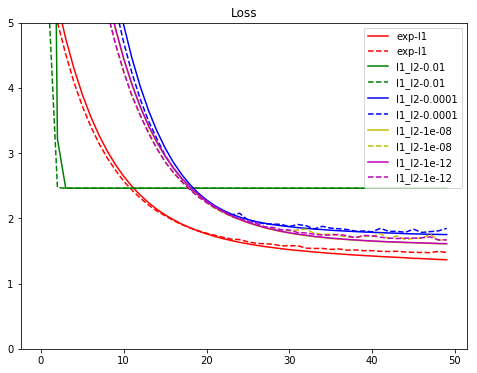

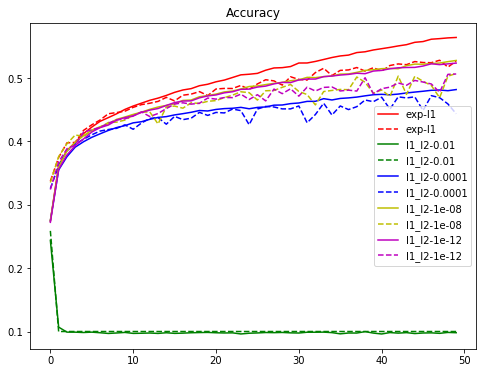

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()